#Self-Driving Taxi Problem solved with OpenAI Gym and Reinforcement Learning





## Introduction:

The Taxi(agent) problem is a reinforcement learning problem where a self driving taxi needs to travel efficiently, avoiding obstacles like walls, and perform pickups and drop-offs at specific locations (on a 5x5 grid). The environment has possible pickup and destination locations for passengers represented by the letters R, Y, G, and B for Red, Yellow, Green, and Blue.

The taxi starts in a random position, and at each episode, the passenger’s location and destination are randomly assigned to one of these four location. The agent must figure out the best sequence of moves to:

1.   Navigate to the passenger’s location,
2.   Pick up the passenger,
3.   Navigate to the dropoff location,
4.   Drop off the passenger successfully.

The agent (the taxi) must navigate the grid, perform the correct sequence of actions, and complete the task in as few steps as possible with maximum reward.



## Installing Libraries

In [ ]:
!pip install gym numpy matplotlib

## Importing Libraries

In [ ]:
import gym
from gym import envs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from time import sleep
import keras
import tensorflow as tf

%matplotlib inline

In [ ]:
print(envs.registry.all())

dict_values([EnvSpec(id='CartPole-v0', entry_point='gym.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=195.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, new_step_api=False, kwargs={}, namespace=None, name='CartPole', version=0), EnvSpec(id='CartPole-v1', entry_point='gym.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, new_step_api=False, kwargs={}, namespace=None, name='CartPole', version=1), EnvSpec(id='MountainCar-v0', entry_point='gym.envs.classic_control.mountain_car:MountainCarEnv', reward_threshold=-110.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, new_step_api=False, kwargs={}, namespace=None, name='MountainCar', version=0), EnvSpec(id='MountainCarContinuous-v0', entry_point='gym.envs.classic_control.co

/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:421: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


## Gym Environment

1. Visual from Text-based Render:
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



2. Visual from RGB Array Render:


/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning

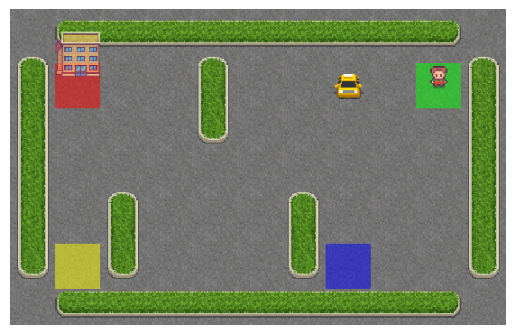

In [ ]:
# Load the Taxi environment
env = gym.make("Taxi-v3", new_step_api=True)

# Reset the environment
state = env.reset()

# Option 1: ANSI (Text-based render) of an environment state
print("1. Visual from Text-based Render:")
print(env.render(mode="ansi"))

# Option 2: RGB Array (Image render)
print("\n2. Visual from RGB Array Render:")
img = env.render(mode="rgb_array")
plt.imshow(img)
plt.axis('off')
plt.show()

#### Here, the possible pickup and destination locations are represented by Red, Green, Yellow and Blue. The blue color/person represents the current passenger pick-up location, and the purple/house is the current destination.

## Action
### There are 6 action commands and each action is indicated by unique number as:
*   0 = move south
*   1 = move north
*   2 = move east
*   3 = move west
*   4 = pickup passenger
*   5 = dropoff passenger

In [ ]:
# Print state and action space dimension
print("Action Space {}".format(env.action_space))
num_actions = env.action_space.n
print("Possible actions: [0,..,%a]" % (num_actions-1))

Action Space Discrete(6)
Possible actions: [0,..,5]


## State
### State: It is a numeric representation of what the agent is observing at a particular moment of time in the environment. This number is a state, usually from 0 and 499

In [ ]:
print("State Space {}".format(env.observation_space))
print("State", state)

State Space Discrete(500)
State 64


In [ ]:
# Manually set environment state
state = env.encode(3, 1, 2, 0)  # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
print(env.render(mode="ansi"))

State: 328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


## Reward
#### The defult values assigned based on the state after taking the action.

In [ ]:
env.P[328] # checking default reward values based on the state from current state

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

This P table is also called reward table. It has dictionary format **action: [(probability_value, next_state, reward_value, status)]}**

Here, the status is bool, True representing dropoff in right location otherwise False

### In Taxi-v3 Environment:

Each timestep, the agent chooses an action, environment returns an observation and a reward.

  **new_state, reward, done, truncated, info = env.step(action)**


  *   new_state (int) : It is the new state after taking the action. The number denotes taxi row, taxi column, passenger and destination location.
  *   reward (int) : It is the reward for taking the action. In Taxi-v3:
        * -1 → A step without reaching the goal (normal movement).
        * -10 → Invalid pickup/dropoff.
        * +20 → Successful dropoff.
  *   done (bool) : It tells whether the episode (game) is finished, with taxi successfully dropped the passenger at the destination
  *   truncated (bool) : It tells if the episode stopped early due to time limit or any reason.
  *   info (dict) : It contains
      * Probability (prob - float) : In Taxi-v3, transitions are deterministic, so it’s always 1.0.
      * 'action_mask'(array - int type):  It tells which actions are valid (1) or invalid (0).

In [ ]:
print("State:", state)

State: 328


In [ ]:
env.reset()
env.s = 328

# Take a random action
action = env.action_space.sample()

# Step the environment
state, reward, done, truncated, info = env.step(action)

# Print results
print('Action:', action)
print("Environment state:", state, reward, done, truncated, info)

Action: 2
Environment state: 454 -1 False False {'prob': 1.0, 'action_mask': array([0, 1, 0, 1, 0, 0], dtype=int8)}


## Solution without RL algorithm - Random Agent

Agent will take a random action.

In [ ]:
%%time

env.reset()

env.s = 328  # set environment to illustration's state

steps = 0
penalty_count = 0
cum_reward = 0
frame_history = []  # Store frames for visualization
done = False
episode = 1  # Initialize episode to 1, or any desired starting value

while not done:
    action = env.action_space.sample()
    state, reward, done, _, info = env.step(action)

    cum_reward += reward

    # Track penalties when the taxi incorrectly picks up or drops off a passenger
    if reward == -10:
      penalty_count += 1

    # Put each rendered frame into dict for animation
    frame_history.append({
        'frame': env.render(mode='ansi'),
        'episode': episode,
        'state': state,
        'action': action,
        'reward': cum_reward
        }
    )

    steps += 1


print("Timesteps taken: {}".format(steps))
print("Penalties incurred: {}".format(penalty_count))

Timesteps taken: 481
Penalties incurred: 154
CPU times: user 57.2 ms, sys: 140 µs, total: 57.4 ms
Wall time: 66.2 ms


## Visualize Random Action
(You can stop it at any point)

In [ ]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action Taken: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(1)

print_frames(frame_history)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Timestep: 8
State: 352
Action Taken: 0
Reward: -8


KeyboardInterrupt: 

Our agent takes thousands of timesteps and makes lots of wrong drop offs. We can run this over and over, but we can't get optimize. Because agent isn't learning from experience, meaning that agent didn't keep track of which action was best for each state.

So, Reinforcement Learning will be the best approach.

## Solution with RL algorithm with Q-Learning

**Q-Learning:** It is a Bellman equation as a simple value iteration update, using the weighted average of the current value and the new information.

Qform.svg

First, we initialize Q-table to a matrix of 500 * 6 zeros:

In [ ]:
%%time

import random
from IPython.display import clear_output

# Initialize Q-table
q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 1.0  # Discount rate
epsilon = 0.1  # Exploration rate
num_episodes = 10000  # Number of episodes

# For tracking metrics
cum_rewards = np.zeros([num_episodes])
total_epochs = np.zeros([num_episodes])
q_deltas = np.zeros([num_episodes])
total_penalties = 0

# Training loop
for episode in range(1, num_episodes + 1):
    state = env.reset()
    done = False
    epochs, penalties, cum_reward = 0, 0, 0
    q_delta = 0

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore action space
        else:
            action = np.argmax(q_table[state])  # Exploit learned values

        next_state, reward, done, _, info = env.step(action)

        # Q-learning update rule
        old_q_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        new_q_value = (1 - alpha) * old_q_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_q_value

        q_delta += abs(new_q_value - old_q_value)

        # Track penalties
        if reward == -10:
            penalties += 1

        cum_reward += reward
        state = next_state
        epochs += 1

    # Store results for analysis
    total_epochs[episode - 1] = epochs
    cum_rewards[episode - 1] = cum_reward
    q_deltas[episode - 1] = q_delta
    total_penalties += penalties

    # Display progress every 100 episodes
    if episode % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {episode}")

print("\nTraining completed.\n")

Episode: 10000

Training completed.

CPU times: user 10.4 s, sys: 1.41 s, total: 11.8 s
Wall time: 11.2 s


## Visualization
###1.   Rewards Per Episode
###2.   Steps Per Episode



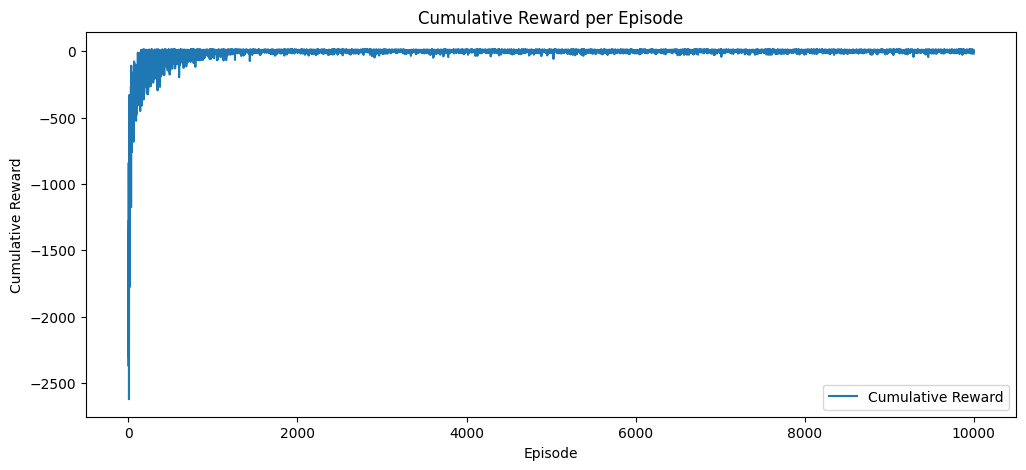

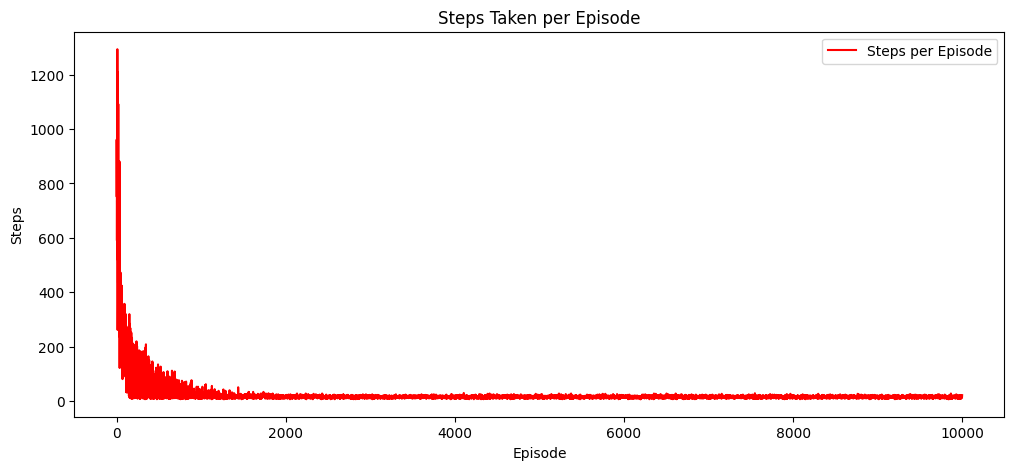

In [ ]:
# Plot cumulative rewards per episode
plt.figure(figsize=(12, 5))
plt.plot(cum_rewards, label="Cumulative Reward")
plt.title("Cumulative Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.show()

# Plot number of epochs per episode
plt.figure(figsize=(12, 5))
plt.plot(total_epochs, label="Steps per Episode", color='r')
plt.title("Steps Taken per Episode")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.legend()
plt.show()


In [ ]:
q_table[328]

array([-1.36585011, 10.9976385 , -4.25124671, -2.79979975, -4.22533697,
       -5.06879145])


###3. Action Value Heatmap for Sample State




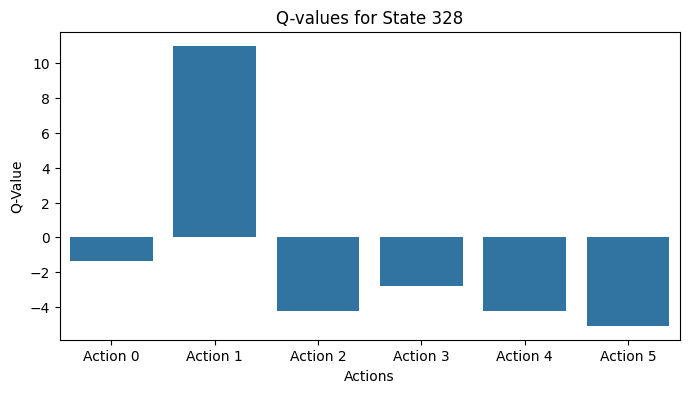

In [ ]:
import seaborn as sns

sample_state = 328  # Arbitrary state
q_values = q_table[sample_state]

plt.figure(figsize=(8, 4))
sns.barplot(x=[f"Action {i}" for i in range(env.action_space.n)], y=q_values)
plt.title(f"Q-values for State {sample_state}")
plt.ylabel("Q-Value")
plt.xlabel("Actions")
plt.show()

###4. Top Learning Episode



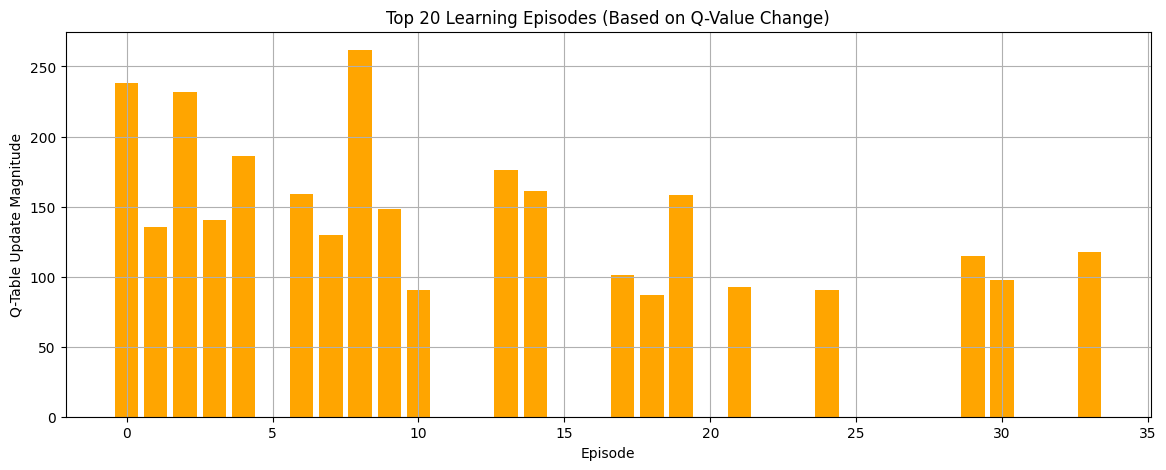

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Top N episodes with highest Q-table change
top_n = 20
top_episodes = np.argsort(q_deltas)[-top_n:]
top_episodes = sorted(top_episodes)

plt.figure(figsize=(14, 5))
plt.bar(top_episodes, q_deltas[top_episodes], color='orange')
plt.title(f"Top {top_n} Learning Episodes (Based on Q-Value Change)")
plt.xlabel("Episode")
plt.ylabel("Q-Table Update Magnitude")
plt.grid(True)
plt.show()


## Performance Comparison of two solution:


1.   Agent taking random action without RL
2.   Agent taking optimal action with RL Q-learning algorithm



In [ ]:
import numpy as np

# Initialize tracking variables
random_agent_rewards = []
random_agent_penalties = []
random_agent_steps = []

q_learning_rewards = []
q_learning_penalties = []
q_learning_steps = []

# Run multiple trials for the random agent
for _ in range(100):
    env.reset()
    env.s = 328  # Set environment to a fixed state
    steps, penalties, cum_reward = 0, 0, 0
    done = False

    while not done:
        action = env.action_space.sample()
        state, reward, done, _, _ = env.step(action)
        cum_reward += reward
        if reward == -10:
            penalties += 1
        steps += 1

    random_agent_rewards.append(cum_reward)
    random_agent_penalties.append(penalties)
    random_agent_steps.append(steps)

# Run multiple trials for the Q-learning agent
for _ in range(100):
    state = env.reset()
    env.s = 328  # Set environment to a fixed state
    steps, penalties, cum_reward = 0, 0, 0
    done = False

    while not done:
        action = np.argmax(q_table[state])  # Choose best learned action
        state, reward, done, _, _ = env.step(action)
        cum_reward += reward
        if reward == -10:
            penalties += 1
        steps += 1

    q_learning_rewards.append(cum_reward)
    q_learning_penalties.append(penalties)
    q_learning_steps.append(steps)

# Compute averages
random_avg_reward = np.mean(random_agent_rewards)
random_avg_penalties = np.mean(random_agent_penalties)
random_avg_steps = np.mean(random_agent_steps)

q_learning_avg_reward = np.mean(q_learning_rewards)
q_learning_avg_penalties = np.mean(q_learning_penalties)
q_learning_avg_steps = np.mean(q_learning_steps)

# Print results
print("Performance Comparison:")
print("\nMeasure\t\t\t\tRandom Agent\tQ-learning Agent")
print(f"Average rewards per move\t{random_avg_reward:.4f}\t{q_learning_avg_reward:.4f}")
print(f"Average penalties per episode\t{random_avg_penalties:.2f}\t\t{q_learning_avg_penalties:.2f}")
print(f"Average timesteps per trip\t{random_avg_steps:.2f}\t\t{q_learning_avg_steps:.2f}")

Performance Comparison:

Measure				Random Agent	Q-learning Agent
Average rewards per move	-8867.0800	7.9500
Average penalties per episode	734.91		0.00
Average timesteps per trip	2273.89		13.05


## Q-Learning Improvement over Random Agent

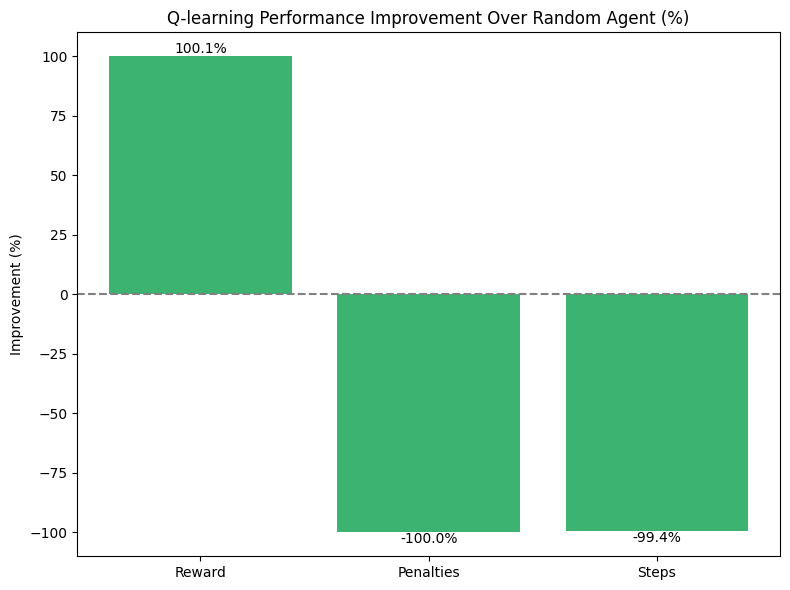

In [ ]:
import matplotlib.pyplot as plt

# Compute percentage change
def pct_change(rand, q):
    return ((q - rand) / abs(rand)) * 100

improvements = [
    pct_change(random_avg_reward, q_learning_avg_reward),
    pct_change(random_avg_penalties, q_learning_avg_penalties),
    pct_change(random_avg_steps, q_learning_avg_steps),
]

labels = ['Reward', 'Penalties', 'Steps']

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, improvements, color='mediumseagreen')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Q-learning Performance Improvement Over Random Agent (%)")
plt.ylabel("Improvement (%)")

# Annotate
for bar, imp in zip(bars, improvements):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{imp:.1f}%",
             ha='center', va='bottom' if imp >= 0 else 'top')

plt.tight_layout()
plt.show()

The Q-learning agent outperformed the random agent across all metrics. It achieved **100.1% better rewards**, indicating it learned to navigate more effectively and avoid negative outcomes. It **completely eliminated penalties (−100%)**, showing it avoided all incorrect or harmful actions. Additionally, it required **99.4% fewer steps** per episode, proving it learned a highly efficient policy to reach the goal quickly.